In [1]:
import folium
import geopandas as gpd
import numpy as np
import pandas as pd

In [ ]:
# JAM.gpq is the GADM 3.6 entry for Jamaica, saved as geoparquet
jamaica_territory = gpd.read_parquet("data/JAM.gpq")
jamaica_territory = jamaica_territory.to_crs(epsg=3448)

# data from UWI 2024-12-6
coastal_protection_geodata_path = "data/Baseline_Projections.gpkg"
nodes = gpd.read_file(coastal_protection_geodata_path, layer="nodes")
assert nodes.crs.to_epsg() == 3448
coast = gpd.read_file(coastal_protection_geodata_path, layer="rp100_coastal_protection")
assert coast.crs.to_epsg() == 3448
coast

ERROR 1: PROJ: proj_create_from_database: Open of /home/fred/micromamba/envs/coastal-protection/share/proj failed


id    from_id      to_id  coast_length  RP100_flood_height_max  \
0        edge_0     node_0     node_1    499.999964                2.205885   
1        edge_1     node_1     node_2    499.999967                2.991306   
2        edge_2     node_2     node_3    499.999975                2.991306   
3        edge_3     node_3     node_4    499.999983                2.991306   
4        edge_4     node_4     node_5    499.999989                2.237110   
...         ...        ...        ...           ...                     ...   
1816  edge_1891  node_1811  node_1812    499.996281                1.815961   
1817  edge_1892  node_1812  node_1813    499.996283                1.885901   
1818  edge_1893  node_1813  node_1814    499.996212                1.885901   
1819  edge_1894  node_1814  node_1815    499.996195                1.885901   
1820  edge_1895  node_1815  node_1862    182.507567                1.885901   

      RP100_range  RP100_protection_height  \
0            2.25                     2.75   
1            3.00                     3.50   
2            3.00                     3.50   
3            3.00                     3.50   
4            2.25                     2.75   
...           ...                      ...   
1816         2.00                     2.50   
1817         2.00                     2.50   
1818         2.00                     2.50   
1819         2.00                     2.50   
1820         2.00                     2.50   

                                               geometry  
0     LINESTRING (769260.578 647564.138, 769252.829 ...  
1     LINESTRING (768858.012 647581.049, 768852.415 ...  
2     LINESTRING (768483.631 647850.543, 768473.558 ...  
3     LINESTRING (768106.811 648177.655, 768092.408 ...  
4     LINESTRING (767730.588 648489.72, 767712.07 64...  
...                                                 ...  
1816  LINESTRING (727282.776 625430.752, 727288.133 ...  
1817  LINESTRING (726936.298 625544.317, 726919.878 ...  
1818  LINESTRING (726503.572 625353.582, 726501.347 ...  
1819  LINESTRING (726835.34 625293.294, 726847.472 6...  
1820  LINESTRING (727078.402 625172.455, 727086.267 ...  

[1821 rows x 8 columns]

index                                           geometry
0        0  POLYGON ((605445.487 678961.741, 605443.374 67...
1        1  POLYGON ((607894.469 689858.849, 607774.713 68...
2        2  POLYGON ((606804.95 681603.369, 606809.648 681...
3        3  POLYGON ((605187.434 680711.064, 605187.695 68...
4        4  POLYGON ((607220.896 676805.145, 607217.345 67...
..     ...                                                ...
461    461  POLYGON ((832005.195 643246.389, 832343.224 64...
462    462  POLYGON ((833097.347 639507.778, 833092.896 63...
463    463  POLYGON ((834540.192 639479.769, 834535.675 63...
464    464  POLYGON ((836532.973 641095.283, 836700.907 64...
465    465  POLYGON ((835383.058 642048.999, 835450.032 64...

[484 rows x 2 columns]

index                                           geometry
0        0  POLYGON ((608743.614 688758.447, 608745.669 68...
1        1  POLYGON ((605219.707 679758.091, 605217.068 67...
2        2  POLYGON ((607848.619 682011.043, 608230.267 68...
3        3  POLYGON ((607220.896 676805.145, 607217.345 67...
4        4  POLYGON ((669327.76 636333.387, 669323.707 636...
..     ...                                                ...
243    243  POLYGON ((828632.965 650589.367, 828637.384 65...
244    244  POLYGON ((831130.947 645420.712, 831131.038 64...
245    245  POLYGON ((835570.512 641460.285, 836185.916 64...
246    246  POLYGON ((832115.666 639468.874, 831960.457 63...
247    247  POLYGON ((835414.337 639087.095, 835409.826 63...

[248 rows x 2 columns]

In [38]:
# buffer coastline some sensible flood protection distance inland
buffer_radius_km = 2
buffer = gpd.GeoDataFrame({"id": [0], "geometry":[coast.geometry.buffer(buffer_radius_km * 1_000).union_all()]})
buffer.crs = coast.crs

# coarsen voronoi by picking every nth node
target_width_km = 4
coast_length_m = round(coast.coast_length.median())
n = int((target_width_km * 1_000) // coast_length_m)
voronoi = nodes.iloc[::n].geometry.voronoi_polygons()

# intersect buffer and voronoi
buffered_voronoi_geoseries = buffer.geometry.iloc[0].intersection(voronoi)
buffer_voronoi_edges = gpd.GeoDataFrame({"geometry": buffered_voronoi_geoseries.boundary})
buffer_voronoi_edges.crs = buffer.crs

buffer_voronoi = gpd.GeoDataFrame({"geometry": buffered_voronoi_geoseries})
buffer_voronoi.crs = buffer.crs

# lookup a valid polygon (closed!) for Jamaican island from multipolygon of Jamaican territory
exploded = jamaica_territory.explode(index_parts=True).reset_index()
main_island_index = exploded.geometry.area.sort_values(ascending=False).index[0]
jamaica_poly = exploded.loc[[main_island_index], :]
jamaica_poly.geometry = jamaica_poly.geometry.buffer(50)
jamaica_coastline = jamaica_poly.boundary

# take the inland portion of the buffered voronoi polygons
inland_buffered_voronoi = jamaica_poly.geometry.iloc[0].intersection(buffer_voronoi)
# opposing headlands of a bay may nearly touch (thus end up in the same voronoi polygon)
# separate these multipolygons with an explode
inland_buffered_voronoi = inland_buffered_voronoi.explode()
inland_buffered_voronoi = inland_buffered_voronoi.reset_index(drop=True).reset_index()
inland_buffered_voronoi.crs = coast.crs
inland_buffered_voronoi_edges = gpd.GeoDataFrame({"geometry": inland_buffered_voronoi.boundary})

f = folium.Figure(width=1000, height=600)
m = coast.explore(tiles="CartoDB positron", column="RP100_flood_height_max")
nodes.explore(m=m, color="red").add_to(f)
buffer_voronoi.explore(m=m, color="purple", style_kwds={"fillOpacity": 0.2}).add_to(f)
inland_buffered_voronoi.explore(m=m, color="blue", style_kwds={"fillOpacity": 0.2}).add_to(f)


<Axes: ylabel='Frequency'>

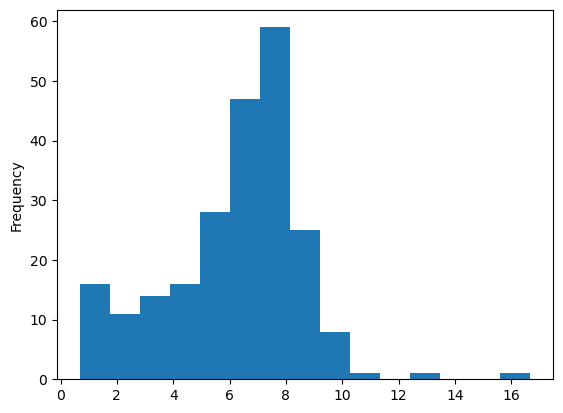

In [48]:
pd.Series(name="area_km2", data=inland_buffered_voronoi.geometry.area / 1E6) \
    .plot.hist(bins=int(np.sqrt(len(inland_buffered_voronoi))))

In [49]:
# merge the smallest polygons with their adjacent polygons
area_threshold_km2 = 2
area_ranking = inland_buffered_voronoi.area.sort_values(ascending=True)
iterations = 0
while any(inland_buffered_voronoi.geometry.area / 1E6 < area_threshold_km2):
    area_ranking = inland_buffered_voronoi.area.sort_values()
    print(f"{iterations:d} {len(inland_buffered_voronoi)} {inland_buffered_voronoi.area.loc[area_ranking.index[0]] / 1E6:.2f}")
    iterations += 1
    min_area_voronoi = inland_buffered_voronoi.loc[area_ranking.index[0]].geometry

    # find the polygons adjacent to the smallest
    grouping_mask = min_area_voronoi.touches(inland_buffered_voronoi.geometry)
    # mark one (the first) to group with the smallest polygon
    first_adjacent_poly_index = grouping_mask.idxmax()
    grouping_mask.loc[:] = False
    grouping_mask[first_adjacent_poly_index] = True
    # set smallest poly as part of the group
    grouping_mask.loc[area_ranking.index[0]] = True

    inland_buffered_voronoi = pd.concat(
        [
            inland_buffered_voronoi.loc[~grouping_mask],
            inland_buffered_voronoi.loc[grouping_mask].dissolve()
        ]
    ).drop(columns=["index"]).reset_index(drop=True).reset_index()
    if iterations > 20:
        print("Hit iteration limit")
        break

f = folium.Figure(width=1000, height=600)
m = coast.explore(tiles="CartoDB positron", column="RP100_flood_height_max")
nodes.explore(m=m, color="red").add_to(f)
inland_buffered_voronoi["area_km2"] = inland_buffered_voronoi.geometry.area / 1E6
inland_buffered_voronoi.explore(m=m, color="blue", style_kwds={"fillOpacity": 0.2}).add_to(f)

0 227 0.67
1 226 0.78
2 225 0.83
3 224 0.84
4 223 0.91
5 222 0.92
6 221 1.10
7 220 1.10
8 219 1.22
9 218 1.39
10 217 1.62
11 216 1.82
12 215 1.83
13 214 1.89
